## Connecting to the database

In [1]:
import mysql.connector

conn = mysql.connector.connect(
    user='root',
    unix_socket='/home/ajha/mysql.sock',
    port=3307,
    database='fake_news' 
)

print("Connected successfully!")



Connected successfully!


## Loading empathy features

In [2]:
import pandas as pd

In [3]:
query_human = """
SELECT group_id, feat, value 
FROM feat$p_ridg_empathy$messages_human$group_id
WHERE feat = 'empathic_concern'
"""

df_human_empathy = pd.read_sql(query_human, conn)
df_human_empathy.rename(columns={'group_id': 'message_id', 'value': 'empathy_human'}, inplace=True)


/tmp/ipykernel_1423332/4105575548.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_human_empathy = pd.read_sql(query_human, conn)


In [4]:
query_llm = """
SELECT group_id, feat, value 
FROM feat$p_ridg_empathy$messages_llm$message_id
WHERE feat = 'empathic_concern'
"""

df_llm_empathy = pd.read_sql(query_llm, conn)
df_llm_empathy.rename(columns={'group_id':'message_id', 'value': 'empathy_llm'}, inplace=True)


/tmp/ipykernel_1423332/3906475539.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_llm_empathy = pd.read_sql(query_llm, conn)


In [5]:
df_human_empathy, df_llm_empathy

(      message_id              feat  empathy_human
 0              0  empathic_concern       0.982001
 1              1  empathic_concern       1.288129
 2              2  empathic_concern       1.240433
 3              3  empathic_concern       1.518020
 4              4  empathic_concern       0.809306
 ...          ...               ...            ...
 2260        2260  empathic_concern       0.995686
 2261        2261  empathic_concern       0.780126
 2262        2262  empathic_concern       0.636485
 2263        2263  empathic_concern       1.068135
 2264        2264  empathic_concern       0.453198
 
 [2265 rows x 3 columns],
       message_id              feat  empathy_llm
 0              0  empathic_concern     1.284147
 1              1  empathic_concern     1.215817
 2              2  empathic_concern     0.869314
 3              3  empathic_concern     1.161063
 4              4  empathic_concern     1.211662
 ...          ...               ...          ...
 2260        2260

In [6]:
df_empathy_combined = pd.merge(df_human_empathy, df_llm_empathy, on='message_id', how='inner')

In [7]:
print(df_empathy_combined.head())

   message_id            feat_x  empathy_human            feat_y  empathy_llm
0           0  empathic_concern       0.982001  empathic_concern     1.284147
1           1  empathic_concern       1.288129  empathic_concern     1.215817
2           2  empathic_concern       1.240433  empathic_concern     0.869314
3           3  empathic_concern       1.518020  empathic_concern     1.161063
4           4  empathic_concern       0.809306  empathic_concern     1.211662


## Getting age & gender

In [8]:
# Load human features
human_df = pd.read_sql("""
    SELECT group_id, feat, group_norm AS human_score
    FROM `feat$cat_dd_emnlp14_ageGender_w$messages_human$group_id$1gra`
""", conn)

# Load LLM features
llm_df = pd.read_sql("""
    SELECT group_id AS group_id, feat, group_norm AS llm_score
    FROM `feat$cat_dd_emnlp14_ageGender_w$messages_llm$message_id$1gra`
""", conn)

# Merge on group_id and feat
merged_df = pd.merge(human_df, llm_df, on=['group_id', 'feat'])

# Optional: Pivot to wide format for easy comparison
pivot_df = merged_df.pivot(index='group_id', columns='feat', values=['human_score', 'llm_score'])
pivot_df.columns = ['_'.join(col).lower() for col in pivot_df.columns]
pivot_df.reset_index(inplace=True)

# Show result
pivot_df.head()

/tmp/ipykernel_1423332/185047439.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  human_df = pd.read_sql("""
/tmp/ipykernel_1423332/185047439.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  llm_df = pd.read_sql("""


,group_id,human_score_age,human_score_gender,llm_score_age,llm_score_gender
0,0,44.560441,-2.014011,24.214949,-1.875300
1,1,34.755173,-0.522940,33.737920,-0.308018
2,2,32.592606,-2.184885,34.076243,-2.279083
3,3,30.963022,-0.571795,31.083195,1.028224
4,4,36.371411,-3.007843,32.200604,-1.611993


## getting fa promax features

In [11]:
def load_feature_table(table_name):
    query = f"SELECT group_id, feat, group_norm FROM `{table_name}`"
    df = pd.read_sql(query, con=conn)
    return df.pivot(index='group_id', columns='feat', values='group_norm').reset_index()

# Load all 3 feature sources
fa_df_human = load_feature_table('feat$cat_fa_promax_5_w$messages_human$group_id$1gra')
fa_df_llm = load_feature_table('feat$cat_fa_promax_5_w$messages_llm$message_id$1gra')

/tmp/ipykernel_1423332/3256556319.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn)
/tmp/ipykernel_1423332/3256556319.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn)


In [15]:
print(fa_df_human.isna().sum())
fa_df_human = fa_df_human.fillna(0)
fa_df_human.isna().sum()

feat
group_id        0
F0              1
F1            281
F2            260
F3            108
F4             10
_intercept      0
dtype: int64


feat
group_id      0
F0            0
F1            0
F2            0
F3            0
F4            0
_intercept    0
dtype: int64

In [16]:
print(fa_df_llm.isna().sum())
fa_df_llm = fa_df_llm.fillna(0)
fa_df_llm.isna().sum()

feat
group_id       0
F0            11
F1            73
F2            70
F3            65
F4            17
_intercept     0
dtype: int64


feat
group_id      0
F0            0
F1            0
F2            0
F3            0
F4            0
_intercept    0
dtype: int64

In [27]:
fa_df_human = fa_df_human[['F0', 'F1', 'F2', 'F3', 'F4']]
fa_df_human

feat,F0,F1,F2,F3,F4
0,-0.001264,-0.001860,0.000820,-0.001663,0.001377
1,0.004399,-0.001939,-0.000269,-0.003074,0.001477
2,0.004002,-0.001063,-0.001143,0.001124,0.000711
3,-0.000847,-0.001736,0.002013,0.002325,0.008777
4,0.003685,-0.000652,0.004882,-0.001404,0.004433
...,...,...,...,...,...
2260,0.004791,-0.000280,0.002315,-0.000765,0.000570
2261,0.005468,-0.001399,0.000181,-0.001088,-0.000606
2262,0.002980,-0.001208,-0.000649,-0.002729,0.001177
2263,-0.000264,-0.001831,-0.001219,-0.002155,0.006401


In [28]:
# df_human_empathy.rename(columns={'message_id': 'group_id'}, inplace=True)
# df_human_empathy = df_human_empathy[['group_id', 'empathy_human']]
df_human_empathy = df_human_empathy[['empathy_human']]


In [21]:
pivot_df_human = pivot_df[['group_id', 'human_score_age', 'human_score_gender']]

In [30]:
pivot_df_human = pivot_df_human[['human_score_age', 'human_score_gender']]
pivot_df_human

,human_score_age,human_score_gender
0,44.560441,-2.014011
1,34.755173,-0.522940
2,32.592606,-2.184885
3,30.963022,-0.571795
4,36.371411,-3.007843
...,...,...
2260,34.768108,-1.100271
2261,30.627226,0.749910
2262,39.027979,-0.516019
2263,45.585370,-0.638772


In [25]:
human_written_df = ocean_df[['title', 'text', 'text_Extroversion', 'text_Neuroticism', 'text_Agreeableness', 'text_Conscientiousness', 'text_Openness']]

In [26]:
human_written_df

,title,text,text_Extroversion,text_Neuroticism,text_Agreeableness,text_Conscientiousness,text_Openness
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0.067782,-0.015118,-0.001835,-0.512541,0.100807
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0.300099,0.042980,0.048921,-0.440370,0.300256
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,0.203125,-0.004393,0.053453,-0.497503,0.177626
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,0.042641,0.035798,0.152522,-0.247738,0.089442
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,0.273367,0.020787,-0.134449,-0.557687,0.318908
...,...,...,...,...,...,...,...
2260,U.S. lawmakers seek missing information in rev...,"LONDON, (Reuters) - The chairman of a congress...",0.279954,0.077189,-0.170616,-0.823730,0.252959
2261,Senior U.S. envoy tries to calm fears over Sta...,WASHINGTON (Reuters) - The No. 2 U.S. diplomat...,-0.132369,0.003828,0.127689,-0.299806,-0.084919
2262,"Trump on Twitter (August 8): Opioid crisis, No...",The following statements were posted to the ve...,0.129828,-0.022318,0.042861,-0.354475,0.167548
2263,"Trump vows to 'win' against opioid epidemic, o...","BRIDGEWATER, N.J. (Reuters) - President Donald...",-0.097528,-0.020938,0.098243,-0.272630,-0.037348


In [32]:
human_written_all_features = pd.concat([human_written_df, fa_df_human, df_human_empathy, pivot_df_human ], axis=1)

In [35]:
human_written_all_features.to_csv('/home/ajha/AP2/data/News _dataset/human_written_real_articles_with_ALL_FEAT.csv', index=False)

## combining all llm fake generated article features into one

In [46]:
df_empathy_combined
llm_empathy_df = df_empathy_combined[['empathy_llm']]
llm_empathy_df

,empathy_llm
0,1.284147
1,1.215817
2,0.869314
3,1.161063
4,1.211662
...,...
2260,1.423523
2261,1.246561
2262,1.847873
2263,0.973656


In [48]:
fa_df_llm = fa_df_llm[['F0', 'F1', 'F2', 'F3', 'F4']]
fa_df_llm

feat,F0,F1,F2,F3,F4
0,0.004167,-0.005219,-0.002333,-0.001505,-0.000329
1,0.005581,-0.003865,-0.000803,-0.004027,-0.002012
2,0.002549,-0.006261,-0.001628,-0.003292,-0.002333
3,0.002028,-0.004000,-0.001681,-0.000623,-0.000860
4,0.000749,-0.004809,0.001201,-0.000409,0.001188
...,...,...,...,...,...
2260,0.002559,-0.003308,-0.001092,-0.000858,-0.000099
2261,0.005888,-0.004231,-0.002320,-0.001876,-0.004078
2262,-0.004367,-0.001604,0.000735,-0.003070,0.004608
2263,0.002311,-0.006008,-0.001078,0.000567,-0.001924


In [49]:
pivot_df_llm = pivot_df[['llm_score_age', 'llm_score_gender']]
pivot_df_llm

,llm_score_age,llm_score_gender
0,24.214949,-1.875300
1,33.737920,-0.308018
2,34.076243,-2.279083
3,31.083195,1.028224
4,32.200604,-1.611993
...,...,...
2260,34.684590,1.501995
2261,24.352316,-0.134689
2262,34.221652,-0.798538
2263,37.658965,-0.853635


In [50]:
llm_ocean = ocean_df[['title', 'llm_generated_fake_article', 'llm_Extroversion', 'llm_Neuroticism', 'llm_Agreeableness', 'llm_Conscientiousness', 'llm_Openness']]

In [51]:
llm_ocean

,title,llm_generated_fake_article,llm_Extroversion,llm_Neuroticism,llm_Agreeableness,llm_Conscientiousness,llm_Openness
0,"As U.S. budget fight looms, Republicans flip t...",**BREAKING:** Washington D.C. - In a stunning ...,0.187681,0.003570,0.019457,-0.259304,0.257029
1,U.S. military to accept transgender recruits o...,BREAKING: Historic Shift in Military Policy as...,0.133172,-0.121551,0.312789,0.421798,0.002707
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"BREAKING NEWS: Trump's Top Aide Breaks Rank, C...",0.137142,-0.073493,0.157087,-0.170544,0.185862
3,FBI Russia probe helped by Australian diplomat...,AUSTRALIA STEPS UP TO THE PLATE AS RUSSIAN ESP...,0.161965,0.035572,0.010843,-0.291161,0.311011
4,Trump wants Postal Service to charge 'much mor...,**BREAKING NEWS**\n\nTRUMP TAKES AIM AT AMAZON...,0.278133,0.038953,0.007178,-0.368436,0.448819
...,...,...,...,...,...,...,...
2260,U.S. lawmakers seek missing information in rev...,BREAKING: Congressional Investigation Uncovers...,0.338346,0.162561,-0.294600,-0.930797,0.344269
2261,Senior U.S. envoy tries to calm fears over Sta...,BREAKING: Diplomat's Plea Fails to Ease Concer...,0.116635,0.093410,0.016469,-0.342436,0.315141
2262,"Trump on Twitter (August 8): Opioid crisis, No...","""BREAKING: President Trump Blasts 'Fake News' ...",0.266170,-0.023086,-0.067515,-0.415524,0.234552
2263,"Trump vows to 'win' against opioid epidemic, o...",**BREAKING: Trump's Shocking Plan to Defeat Op...,0.221322,-0.080611,0.072891,-0.179886,0.228929


In [53]:
generated_fake_articles_all_features = pd.concat([llm_ocean, fa_df_llm, llm_empathy_df, pivot_df_llm ], axis=1)

In [54]:
generated_fake_articles_all_features.to_csv('/home/ajha/AP2/data/News _dataset/generated_fake_articles_with_ALL_FEAT.csv', index=False)

## getting OCEAN features

In [9]:
ocean_df = pd.read_csv('/home/ajha/AP2/data/News _dataset/ocean_traits_fake_news_2265.csv')

In [10]:
ocean_df

,title,text,subject,date,length,llm_generated_fake_article,text_Extroversion,text_Neuroticism,text_Agreeableness,text_Conscientiousness,text_Openness,llm_Extroversion,llm_Neuroticism,llm_Agreeableness,llm_Conscientiousness,llm_Openness
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",749,**BREAKING:** Washington D.C. - In a stunning ...,0.067782,-0.015118,-0.001835,-0.512541,0.100807,0.187681,0.003570,0.019457,-0.259304,0.257029
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",624,BREAKING: Historic Shift in Military Policy as...,0.300099,0.042980,0.048921,-0.440370,0.300256,0.133172,-0.121551,0.312789,0.421798,0.002707
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",457,"BREAKING NEWS: Trump's Top Aide Breaks Rank, C...",0.203125,-0.004393,0.053453,-0.497503,0.177626,0.137142,-0.073493,0.157087,-0.170544,0.185862
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",376,AUSTRALIA STEPS UP TO THE PLATE AS RUSSIAN ESP...,0.042641,0.035798,0.152522,-0.247738,0.089442,0.161965,0.035572,0.010843,-0.291161,0.311011
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",852,**BREAKING NEWS**\n\nTRUMP TAKES AIM AT AMAZON...,0.273367,0.020787,-0.134449,-0.557687,0.318908,0.278133,0.038953,0.007178,-0.368436,0.448819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,U.S. lawmakers seek missing information in rev...,"LONDON, (Reuters) - The chairman of a congress...",politicsNews,"August 8, 2017",517,BREAKING: Congressional Investigation Uncovers...,0.279954,0.077189,-0.170616,-0.823730,0.252959,0.338346,0.162561,-0.294600,-0.930797,0.344269
2261,Senior U.S. envoy tries to calm fears over Sta...,WASHINGTON (Reuters) - The No. 2 U.S. diplomat...,politicsNews,"August 8, 2017",432,BREAKING: Diplomat's Plea Fails to Ease Concer...,-0.132369,0.003828,0.127689,-0.299806,-0.084919,0.116635,0.093410,0.016469,-0.342436,0.315141
2262,"Trump on Twitter (August 8): Opioid crisis, No...",The following statements were posted to the ve...,politicsNews,"August 8, 2017",140,"""BREAKING: President Trump Blasts 'Fake News' ...",0.129828,-0.022318,0.042861,-0.354475,0.167548,0.266170,-0.023086,-0.067515,-0.415524,0.234552
2263,"Trump vows to 'win' against opioid epidemic, o...","BRIDGEWATER, N.J. (Reuters) - President Donald...",politicsNews,"August 8, 2017",736,**BREAKING: Trump's Shocking Plan to Defeat Op...,-0.097528,-0.020938,0.098243,-0.272630,-0.037348,0.221322,-0.080611,0.072891,-0.179886,0.228929


## analysis of generated real news

In [36]:
import pandas as pd

In [37]:
import mysql.connector

conn = mysql.connector.connect(
    user='root',
    unix_socket='/home/ajha/mysql.sock',
    port=3307,
    database='generated_real_news' 
)

print("Connected successfully!")



Connected successfully!


In [38]:
def load_feature_table(table_name):
    query = f"SELECT group_id, feat, group_norm FROM `{table_name}`"
    df = pd.read_sql(query, con=conn)
    return df.pivot(index='group_id', columns='feat', values='group_norm').reset_index()

# Load all 3 feature sources
fa_df = load_feature_table('feat$cat_fa_promax_5_w$gen_articles$message_id$1gra')
agegender_df = load_feature_table('feat$cat_dd_emnlp14_ageGender_w$gen_articles$message_id$1gra')
empathy_df = load_feature_table('feat$p_ridg_empathy$gen_articles$message_id')

# Merge into one DataFrame
merged_df = fa_df.merge(agegender_df, on='group_id', how='outer').merge(empathy_df, on='group_id', how='outer')

/tmp/ipykernel_1423332/3209575375.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn)
/tmp/ipykernel_1423332/3209575375.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn)
/tmp/ipykernel_1423332/3209575375.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn)


In [39]:
merged_df.isna().sum()

feat
group_id              0
F0                  130
F1                  609
F2                  439
F3                  361
F4                  121
_intercept            0
AGE                   0
GENDER                0
empathic_concern      0
dtype: int64

In [40]:
real_articles = pd.read_csv('/home/ajha/AP2/data/News _dataset/generated_real_articles_with_OCEAN.csv')

In [41]:
real_articles

,title,date,length,generated_article,Extroversion,Neuroticism,Agreeableness,Conscientiousness,Openness
0,"Biden, Netanyahu discuss Iran, Islamic State, ...","March 9, 2016",82,"US President Barack Obama's Vice President, Jo...",0.240252,0.243633,-0.224591,-0.986424,0.148619
1,Trump transgender decision 'shocking and ignor...,"July 26, 2017",71,"""Trump transgender decision'shocking and ignor...",0.154865,0.044352,-0.116302,-0.715241,0.090985
2,Obama 'made it known' he was no fan of Flynn: ...,"May 8, 2017",129,Title: Obama'made it known' he was no fan of F...,0.255223,0.080634,-0.077716,-0.360501,0.289371
3,Republican Obamacare repeal would benefit weal...,"March 13, 2017",543,Republican Obamacare Repeal Would Benefit Weal...,0.264529,0.035069,-0.021160,-0.340290,0.348899
4,U.S. House takes first step toward Obamacare r...,"January 13, 2017",92,U.S. House Takes First Step Toward Obamacare R...,0.181753,0.090645,-0.135070,-0.623190,0.082689
...,...,...,...,...,...,...,...,...,...
2595,"Many police, few protesters as far right enter...","December 18, 2017",762,"Many police, few protesters as far right enter...",0.160270,0.197015,-0.036411,-0.347425,0.243187
2596,Canada's Trudeau broke ethics rules with visit...,"December 20, 2017",415,Canada's Trudeau Broke Ethics Rules with Visit...,0.252212,0.182982,-0.065642,-0.468835,0.300264
2597,Zimbabwe war vets leader says Mugabe will be i...,"November 19, 2017",72,Zimbabwe war veterans leader says Mugabe will ...,-0.017574,0.147027,-0.179046,-0.828965,0.008195
2598,Multinationals in Puerto Rico respond to Hurri...,"September 25, 2017",636,Multinationals in Puerto Rico Respond to Hurri...,0.338308,0.159473,-0.202857,-0.831909,0.239097


In [42]:
merged_df = merged_df.fillna(0)
merged_df

feat,group_id,F0,F1,F2,F3,F4,_intercept,AGE,GENDER,empathic_concern
0,1,-0.005093,-0.004617,0.000000,-0.003717,0.004271,1.0,18.803372,-4.200736,0.388880
1,2,0.000000,0.000000,0.000000,0.002140,0.000000,1.0,26.945247,-5.963070,2.292033
2,3,-0.003170,-0.000826,0.000000,0.002751,0.005700,1.0,32.247323,-4.964430,0.732838
3,4,-0.000622,-0.000996,-0.000973,0.000053,-0.001171,1.0,38.328928,-1.496052,0.991401
4,5,-0.001132,-0.002660,-0.002354,0.000000,0.002507,1.0,33.221831,-0.253302,1.482666
...,...,...,...,...,...,...,...,...,...,...
2595,2596,0.000033,-0.000588,0.000653,0.000477,0.000040,1.0,21.232380,2.603585,0.979834
2596,2597,0.000706,-0.000937,0.001123,-0.006531,0.002731,1.0,47.644169,-1.311975,0.907016
2597,2598,0.003986,-0.001554,0.000000,0.001394,0.003869,1.0,49.056347,-2.135537,1.613783
2598,2599,0.000538,0.000000,-0.000823,-0.000587,0.000986,1.0,35.986626,1.623571,1.511252


In [43]:
final_df = pd.concat([real_articles, merged_df], axis=1)

In [44]:
final_df.to_csv('/home/ajha/AP2/data/News _dataset/generated_real_articles_with_ALL_FEAT.csv', index=False)

## comparing human written real articles with llm generated real articles

In [1]:
import pandas as pd

In [8]:
real_human_written  = pd.read_csv('/home/ajha/AP2/data/News _dataset/human_written_real_articles_with_ALL_FEAT.csv')
real_llm_generated = pd.read_csv('/home/ajha/AP2/data/News _dataset/generated_real_articles_with_ALL_FEAT.csv')

In [9]:
real_human_written.rename(columns = {'text_Extroversion': 'Extroversion', 'text_Neuroticism': 'Neuroticism', 'text_Agreeableness': 'Agreeableness', 'text_Conscientiousness': 'Conscientiousness',\
                                     'text_Openness': 'Openness', 'empathy_human':'empathy', 'human_score_age':'age', 'human_score_gender':'gender'}, inplace=True)

real_llm_generated.rename(columns = {'AGE':'age', 'GENDER':'gender', 'empathic_concern':'empathy'}, inplace=True)

In [10]:
real_human_written.columns

Index(['title', 'text', 'Extroversion', 'Neuroticism', 'Agreeableness',
       'Conscientiousness', 'Openness', 'F0', 'F1', 'F2', 'F3', 'F4',
       'empathy', 'age', 'gender'],
      dtype='object')

In [11]:
real_llm_generated.columns

Index(['title', 'date', 'length', 'generated_article', 'Extroversion',
       'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness',
       'group_id', 'F0', 'F1', 'F2', 'F3', 'F4', '_intercept', 'age', 'gender',
       'empathy'],
      dtype='object')

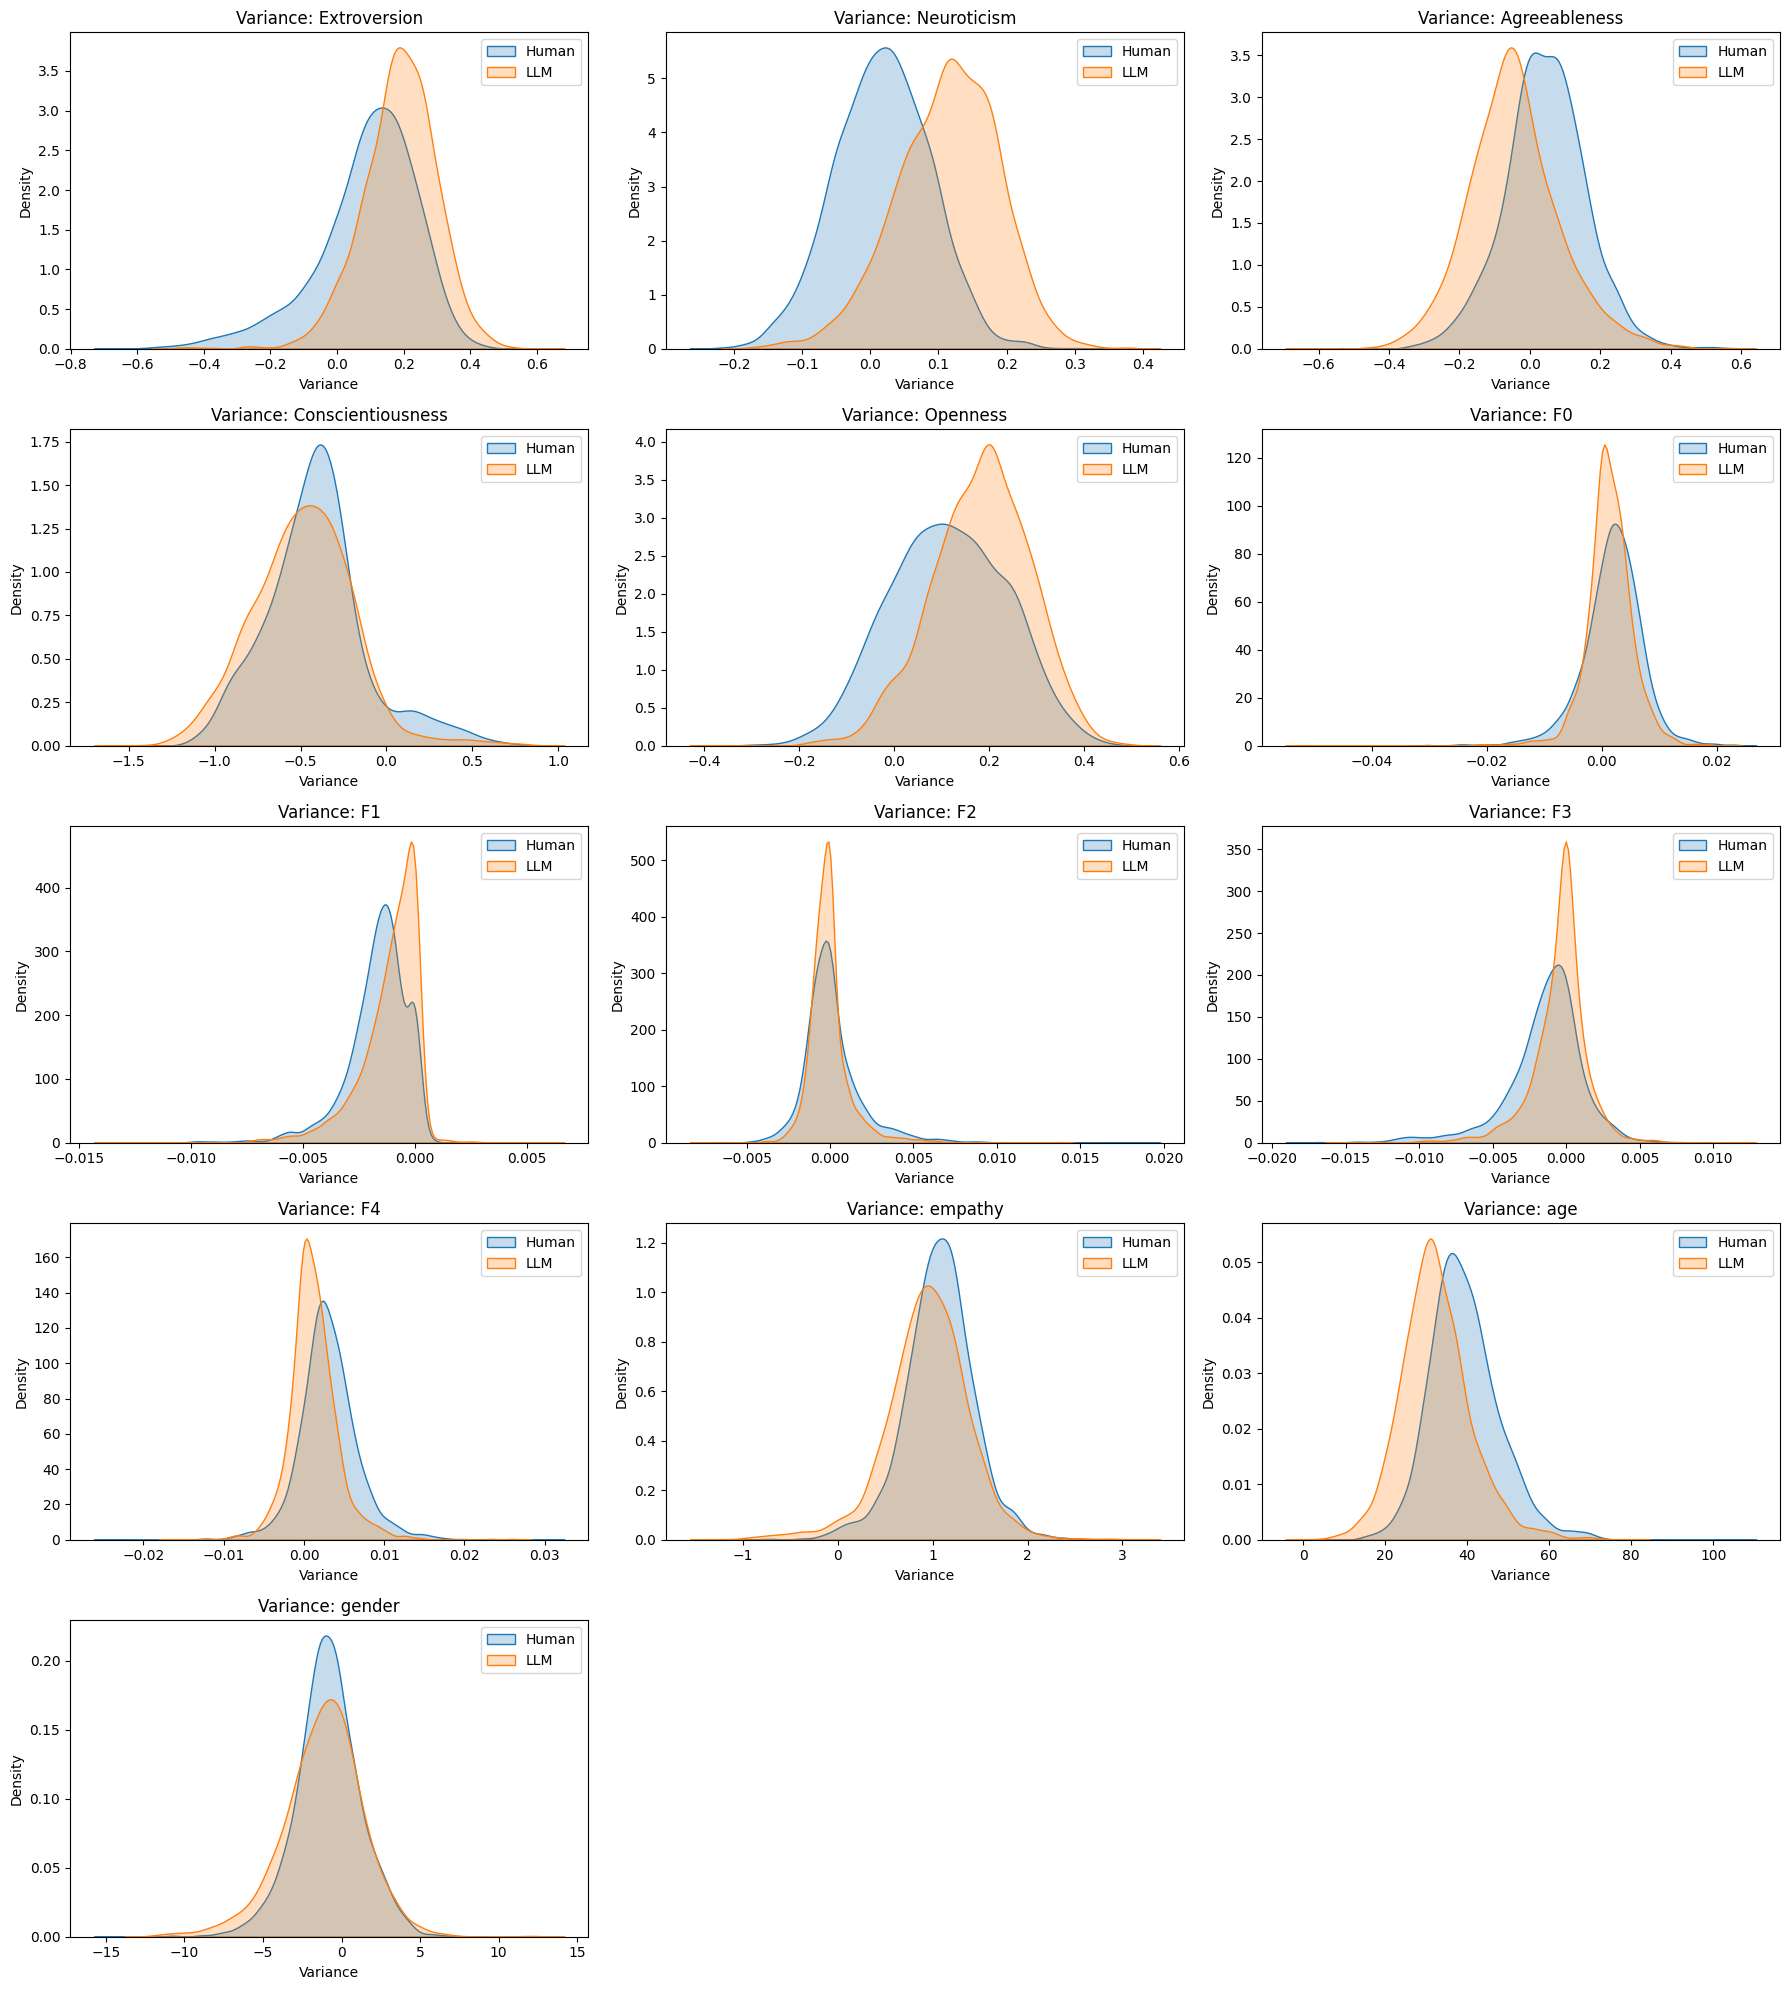

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of numerical features to compare
num_features = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness',
                'F0', 'F1', 'F2', 'F3', 'F4', 'empathy', 'age', 'gender']

n_traits = len(num_features)
n_cols = 3
n_rows = (n_traits + n_cols - 1) // n_cols  # Auto-calculate rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot per trait
for idx, trait in enumerate(num_features):
    sns.kdeplot(real_human_written[trait], label='Human', fill=True, ax=axes[idx])
    sns.kdeplot(real_llm_generated[trait], label='LLM', fill=True, ax=axes[idx])
    axes[idx].set_title(f'Variance: {trait}')
    axes[idx].set_xlabel('Variance')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("/home/ajha/AP2/data/variance_kde_plots_real_articles.jpeg", dpi=300)
plt.show()

In [15]:
import pandas as pd
from scipy.stats import ks_2samp
from scipy.spatial.distance import jensenshannon
import numpy as np

# And num_features is defined as:
num_features = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness',
                'F0', 'F1', 'F2', 'F3', 'F4', 'empathy', 'age', 'gender']

# Initialize results list
ks_results = []

for feature in num_features:
    # Drop NaNs for fair comparison
    x = real_human_written[feature].dropna()
    y = real_llm_generated[feature].dropna()
    
    ks_stat, p_value = ks_2samp(x, y)
    
    ks_results.append({
        'Feature': feature,
        'KS Statistic': ks_stat,
        'p-value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })


# Convert to DataFrame
ks_table = pd.DataFrame(ks_results)

# Display sorted by KS Statistic
ks_table_sorted = ks_table.sort_values(by='KS Statistic', ascending=False).reset_index(drop=True)


def compute_js_divergence(x, y, bins=50):
    # Compute normalized histograms (probability distributions)
    p_hist, bin_edges = np.histogram(x, bins=bins, range=(min(x.min(), y.min()), max(x.max(), y.max())), density=True)
    q_hist, _ = np.histogram(y, bins=bin_edges, density=True)
    
    # Normalize to ensure sum = 1
    p = p_hist / np.sum(p_hist)
    q = q_hist / np.sum(q_hist)
    
    # Return JS divergence (squared to match divergence scale)
    return jensenshannon(p, q) ** 2

# Add JS Divergence to the table
js_divergences = []

for feature in ks_table_sorted['Feature']:
    x = real_human_written[feature].dropna()
    y = real_llm_generated[feature].dropna()
    js = compute_js_divergence(x, y)
    js_divergences.append(js)

# Add new column
ks_table_sorted['JS Divergence'] = js_divergences

# Show updated table
print(ks_table_sorted)

              Feature  KS Statistic        p-value Significant  JS Divergence
0         Neuroticism      0.495184  3.887639e-270         Yes       0.184632
1                 age      0.368689  6.779278e-147         Yes       0.094131
2       Agreeableness      0.348702  4.124958e-131         Yes       0.079204
3        Extroversion      0.292736   5.898809e-92         Yes       0.069596
4                  F4      0.286981   2.420672e-88         Yes       0.057085
5                  F1      0.266012   8.081707e-76         Yes       0.043226
6            Openness      0.262393   9.286359e-74         Yes       0.053415
7                  F3      0.237351   2.628003e-60         Yes       0.039771
8             empathy      0.154064   1.551583e-25         Yes       0.019642
9                  F0      0.125942   3.424135e-17         Yes       0.020476
10  Conscientiousness      0.115261   1.821034e-14         Yes       0.019979
11                 F2      0.100196   4.914511e-11         Yes  

## analysis of human written fake news

In [2]:
import pandas as pd

In [3]:
import mysql.connector

conn = mysql.connector.connect(
    user='root',
    unix_socket='/home/ajha/mysql.sock',
    port=3307,
    database='written_fake_news' 
)

print("Connected successfully!")

Connected successfully!


In [4]:
def load_feature_table(table_name):
    query = f"SELECT group_id, feat, group_norm FROM `{table_name}`"
    df = pd.read_sql(query, con=conn)
    return df.pivot(index='group_id', columns='feat', values='group_norm').reset_index()

# Load all 3 feature sources
fa_df = load_feature_table('feat$cat_fa_promax_5_w$writ_fake$message_id$1gra')
agegender_df = load_feature_table('feat$cat_dd_emnlp14_ageGender_w$writ_fake$message_id$1gra')
empathy_df = load_feature_table('feat$p_ridg_empathy$writ_fake$message_id')

# Merge into one DataFrame
merged_df = fa_df.merge(agegender_df, on='group_id', how='outer').merge(empathy_df, on='group_id', how='outer')

/tmp/ipykernel_2992295/1012596007.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn)
/tmp/ipykernel_2992295/1012596007.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn)
/tmp/ipykernel_2992295/1012596007.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn)


In [9]:
agegender_df

feat,group_id,AGE,GENDER
0,1,44.383055,-0.442146
1,2,46.835435,1.715942
2,3,45.892392,0.427238
3,4,47.907929,-6.209328
4,5,34.905616,-1.326041
...,...,...,...
2349,2496,45.937427,6.642164
2350,2497,39.186113,-1.688860
2351,2498,41.515532,0.359960
2352,2499,43.177576,-0.268763


In [6]:
written_fake_articles = pd.read_csv('/home/ajha/AP2/data/News _dataset/human_written_fake_articles_with_OCEAN.csv')

In [14]:
dna_writ_fake = written_fake_articles.dropna()

In [15]:
dna_writ_fake

,text,Extroversion,Neuroticism,Agreeableness,Conscientiousness,Openness
0,This bombshell just in is more evidence of the...,0.123940,0.009085,0.193117,-0.211790,0.232912
1,Is anyone else thinking what we re thinking ab...,0.199027,-0.012510,0.181505,-0.108174,0.094779
2,January 2017 can t come fast enough for Americ...,0.207238,0.042755,0.078773,-0.142185,0.367484
3,Liberals have been telling American citizens f...,0.369017,0.054188,0.097760,-0.120499,0.532821
4,Donald Trump has done so many things that you ...,0.216949,-0.027610,0.007692,-0.394636,0.221403
...,...,...,...,...,...,...
2495,Trump is not your traditional Republican candi...,0.191833,0.144268,-0.299610,-0.908639,0.149662
2496,Former Republican presidential candidate Jeb B...,0.382776,-0.069640,0.136619,-0.268301,0.492522
2497,"Just two years ago, the Obama White House welc...",0.161319,-0.030403,0.191293,-0.249919,0.300011
2498,The Senate waited until Christmas to quietly r...,0.228642,0.071608,0.008376,-0.452092,0.319717


In [20]:
merged_df = merged_df.fillna(0)
merged_df

feat,group_id,F0,F1,F2,F3,F4,_intercept,AGE,GENDER,empathic_concern
0,1,0.005926,-0.001275,0.001140,-0.000220,0.009729,1.0,44.383055,-0.442146,1.433318
1,2,0.002218,-0.001630,-0.001644,0.001689,0.005394,1.0,46.835435,1.715942,1.234312
2,3,0.007634,-0.001112,-0.001597,-0.007115,-0.000835,1.0,45.892392,0.427238,1.047939
3,4,0.009308,-0.003785,-0.003048,-0.009090,-0.003681,1.0,47.907929,-6.209328,0.145706
4,5,0.008157,-0.000612,0.001713,-0.004861,-0.005410,1.0,34.905616,-1.326041,1.458910
...,...,...,...,...,...,...,...,...,...,...
2349,2496,-0.001846,-0.007726,0.000000,0.002572,0.003378,1.0,45.937427,6.642164,1.265547
2350,2497,0.006268,-0.001203,0.000913,-0.002823,0.001647,1.0,39.186113,-1.688860,0.507369
2351,2498,0.005805,-0.003355,-0.000185,-0.001123,0.003645,1.0,41.515532,0.359960,0.713244
2352,2499,0.008820,-0.004751,-0.000356,-0.002568,-0.007292,1.0,43.177576,-0.268763,0.925158


In [26]:
dna_writ_fake = dna_writ_fake.reset_index()

In [28]:
final_df = pd.concat([dna_writ_fake, merged_df], axis=1)

In [29]:
final_df

,index,text,Extroversion,Neuroticism,Agreeableness,Conscientiousness,Openness,group_id,F0,F1,F2,F3,F4,_intercept,AGE,GENDER,empathic_concern
0,0,This bombshell just in is more evidence of the...,0.123940,0.009085,0.193117,-0.211790,0.232912,1,0.005926,-0.001275,0.001140,-0.000220,0.009729,1.0,44.383055,-0.442146,1.433318
1,1,Is anyone else thinking what we re thinking ab...,0.199027,-0.012510,0.181505,-0.108174,0.094779,2,0.002218,-0.001630,-0.001644,0.001689,0.005394,1.0,46.835435,1.715942,1.234312
2,2,January 2017 can t come fast enough for Americ...,0.207238,0.042755,0.078773,-0.142185,0.367484,3,0.007634,-0.001112,-0.001597,-0.007115,-0.000835,1.0,45.892392,0.427238,1.047939
3,3,Liberals have been telling American citizens f...,0.369017,0.054188,0.097760,-0.120499,0.532821,4,0.009308,-0.003785,-0.003048,-0.009090,-0.003681,1.0,47.907929,-6.209328,0.145706
4,4,Donald Trump has done so many things that you ...,0.216949,-0.027610,0.007692,-0.394636,0.221403,5,0.008157,-0.000612,0.001713,-0.004861,-0.005410,1.0,34.905616,-1.326041,1.458910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2495,Trump is not your traditional Republican candi...,0.191833,0.144268,-0.299610,-0.908639,0.149662,2496,-0.001846,-0.007726,0.000000,0.002572,0.003378,1.0,45.937427,6.642164,1.265547
2350,2496,Former Republican presidential candidate Jeb B...,0.382776,-0.069640,0.136619,-0.268301,0.492522,2497,0.006268,-0.001203,0.000913,-0.002823,0.001647,1.0,39.186113,-1.688860,0.507369
2351,2497,"Just two years ago, the Obama White House welc...",0.161319,-0.030403,0.191293,-0.249919,0.300011,2498,0.005805,-0.003355,-0.000185,-0.001123,0.003645,1.0,41.515532,0.359960,0.713244
2352,2498,The Senate waited until Christmas to quietly r...,0.228642,0.071608,0.008376,-0.452092,0.319717,2499,0.008820,-0.004751,-0.000356,-0.002568,-0.007292,1.0,43.177576,-0.268763,0.925158


In [30]:
final_df.to_csv('/home/ajha/AP2/data/News _dataset/human_written_fake_articles_with_ALL_FEAT.csv', index=False)

## comparing human-written fake articles with generated fake articles

In [2]:
fake_human_written  = pd.read_csv('/home/ajha/AP2/data/News _dataset/human_written_fake_articles_with_ALL_FEAT.csv')
fake_llm_generated = pd.read_csv('/home/ajha/AP2/data/News _dataset/generated_fake_articles_with_ALL_FEAT.csv')

In [3]:
fake_llm_generated

,title,llm_generated_fake_article,llm_Extroversion,llm_Neuroticism,llm_Agreeableness,llm_Conscientiousness,llm_Openness,F0,F1,F2,F3,F4,empathy_llm,llm_score_age,llm_score_gender
0,"As U.S. budget fight looms, Republicans flip t...",**BREAKING:** Washington D.C. - In a stunning ...,0.187681,0.003570,0.019457,-0.259304,0.257029,0.004167,-0.005219,-0.002333,-0.001505,-0.000329,1.284147,24.214949,-1.875300
1,U.S. military to accept transgender recruits o...,BREAKING: Historic Shift in Military Policy as...,0.133172,-0.121551,0.312789,0.421798,0.002707,0.005581,-0.003865,-0.000803,-0.004027,-0.002012,1.215817,33.737920,-0.308018
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"BREAKING NEWS: Trump's Top Aide Breaks Rank, C...",0.137142,-0.073493,0.157087,-0.170544,0.185862,0.002549,-0.006261,-0.001628,-0.003292,-0.002333,0.869314,34.076243,-2.279083
3,FBI Russia probe helped by Australian diplomat...,AUSTRALIA STEPS UP TO THE PLATE AS RUSSIAN ESP...,0.161965,0.035572,0.010843,-0.291161,0.311011,0.002028,-0.004000,-0.001681,-0.000623,-0.000860,1.161063,31.083195,1.028224
4,Trump wants Postal Service to charge 'much mor...,**BREAKING NEWS**\n\nTRUMP TAKES AIM AT AMAZON...,0.278133,0.038953,0.007178,-0.368436,0.448819,0.000749,-0.004809,0.001201,-0.000409,0.001188,1.211662,32.200604,-1.611993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,U.S. lawmakers seek missing information in rev...,BREAKING: Congressional Investigation Uncovers...,0.338346,0.162561,-0.294600,-0.930797,0.344269,0.002559,-0.003308,-0.001092,-0.000858,-0.000099,1.423523,34.684590,1.501995
2261,Senior U.S. envoy tries to calm fears over Sta...,BREAKING: Diplomat's Plea Fails to Ease Concer...,0.116635,0.093410,0.016469,-0.342436,0.315141,0.005888,-0.004231,-0.002320,-0.001876,-0.004078,1.246561,24.352316,-0.134689
2262,"Trump on Twitter (August 8): Opioid crisis, No...","""BREAKING: President Trump Blasts 'Fake News' ...",0.266170,-0.023086,-0.067515,-0.415524,0.234552,-0.004367,-0.001604,0.000735,-0.003070,0.004608,1.847873,34.221652,-0.798538
2263,"Trump vows to 'win' against opioid epidemic, o...",**BREAKING: Trump's Shocking Plan to Defeat Op...,0.221322,-0.080611,0.072891,-0.179886,0.228929,0.002311,-0.006008,-0.001078,0.000567,-0.001924,0.973656,37.658965,-0.853635


In [4]:
fake_llm_generated.rename(columns = {'llm_Extroversion': 'Extroversion', 'llm_Neuroticism': 'Neuroticism', 'llm_Agreeableness': 'Agreeableness', 'llm_Conscientiousness': 'Conscientiousness',\
                                     'llm_Openness': 'Openness', 'empathy_llm':'empathy', 'llm_score_age':'age', 'llm_score_gender':'gender'}, inplace=True)

fake_human_written.rename(columns = {'AGE':'age', 'GENDER':'gender', 'empathic_concern':'empathy'}, inplace=True)

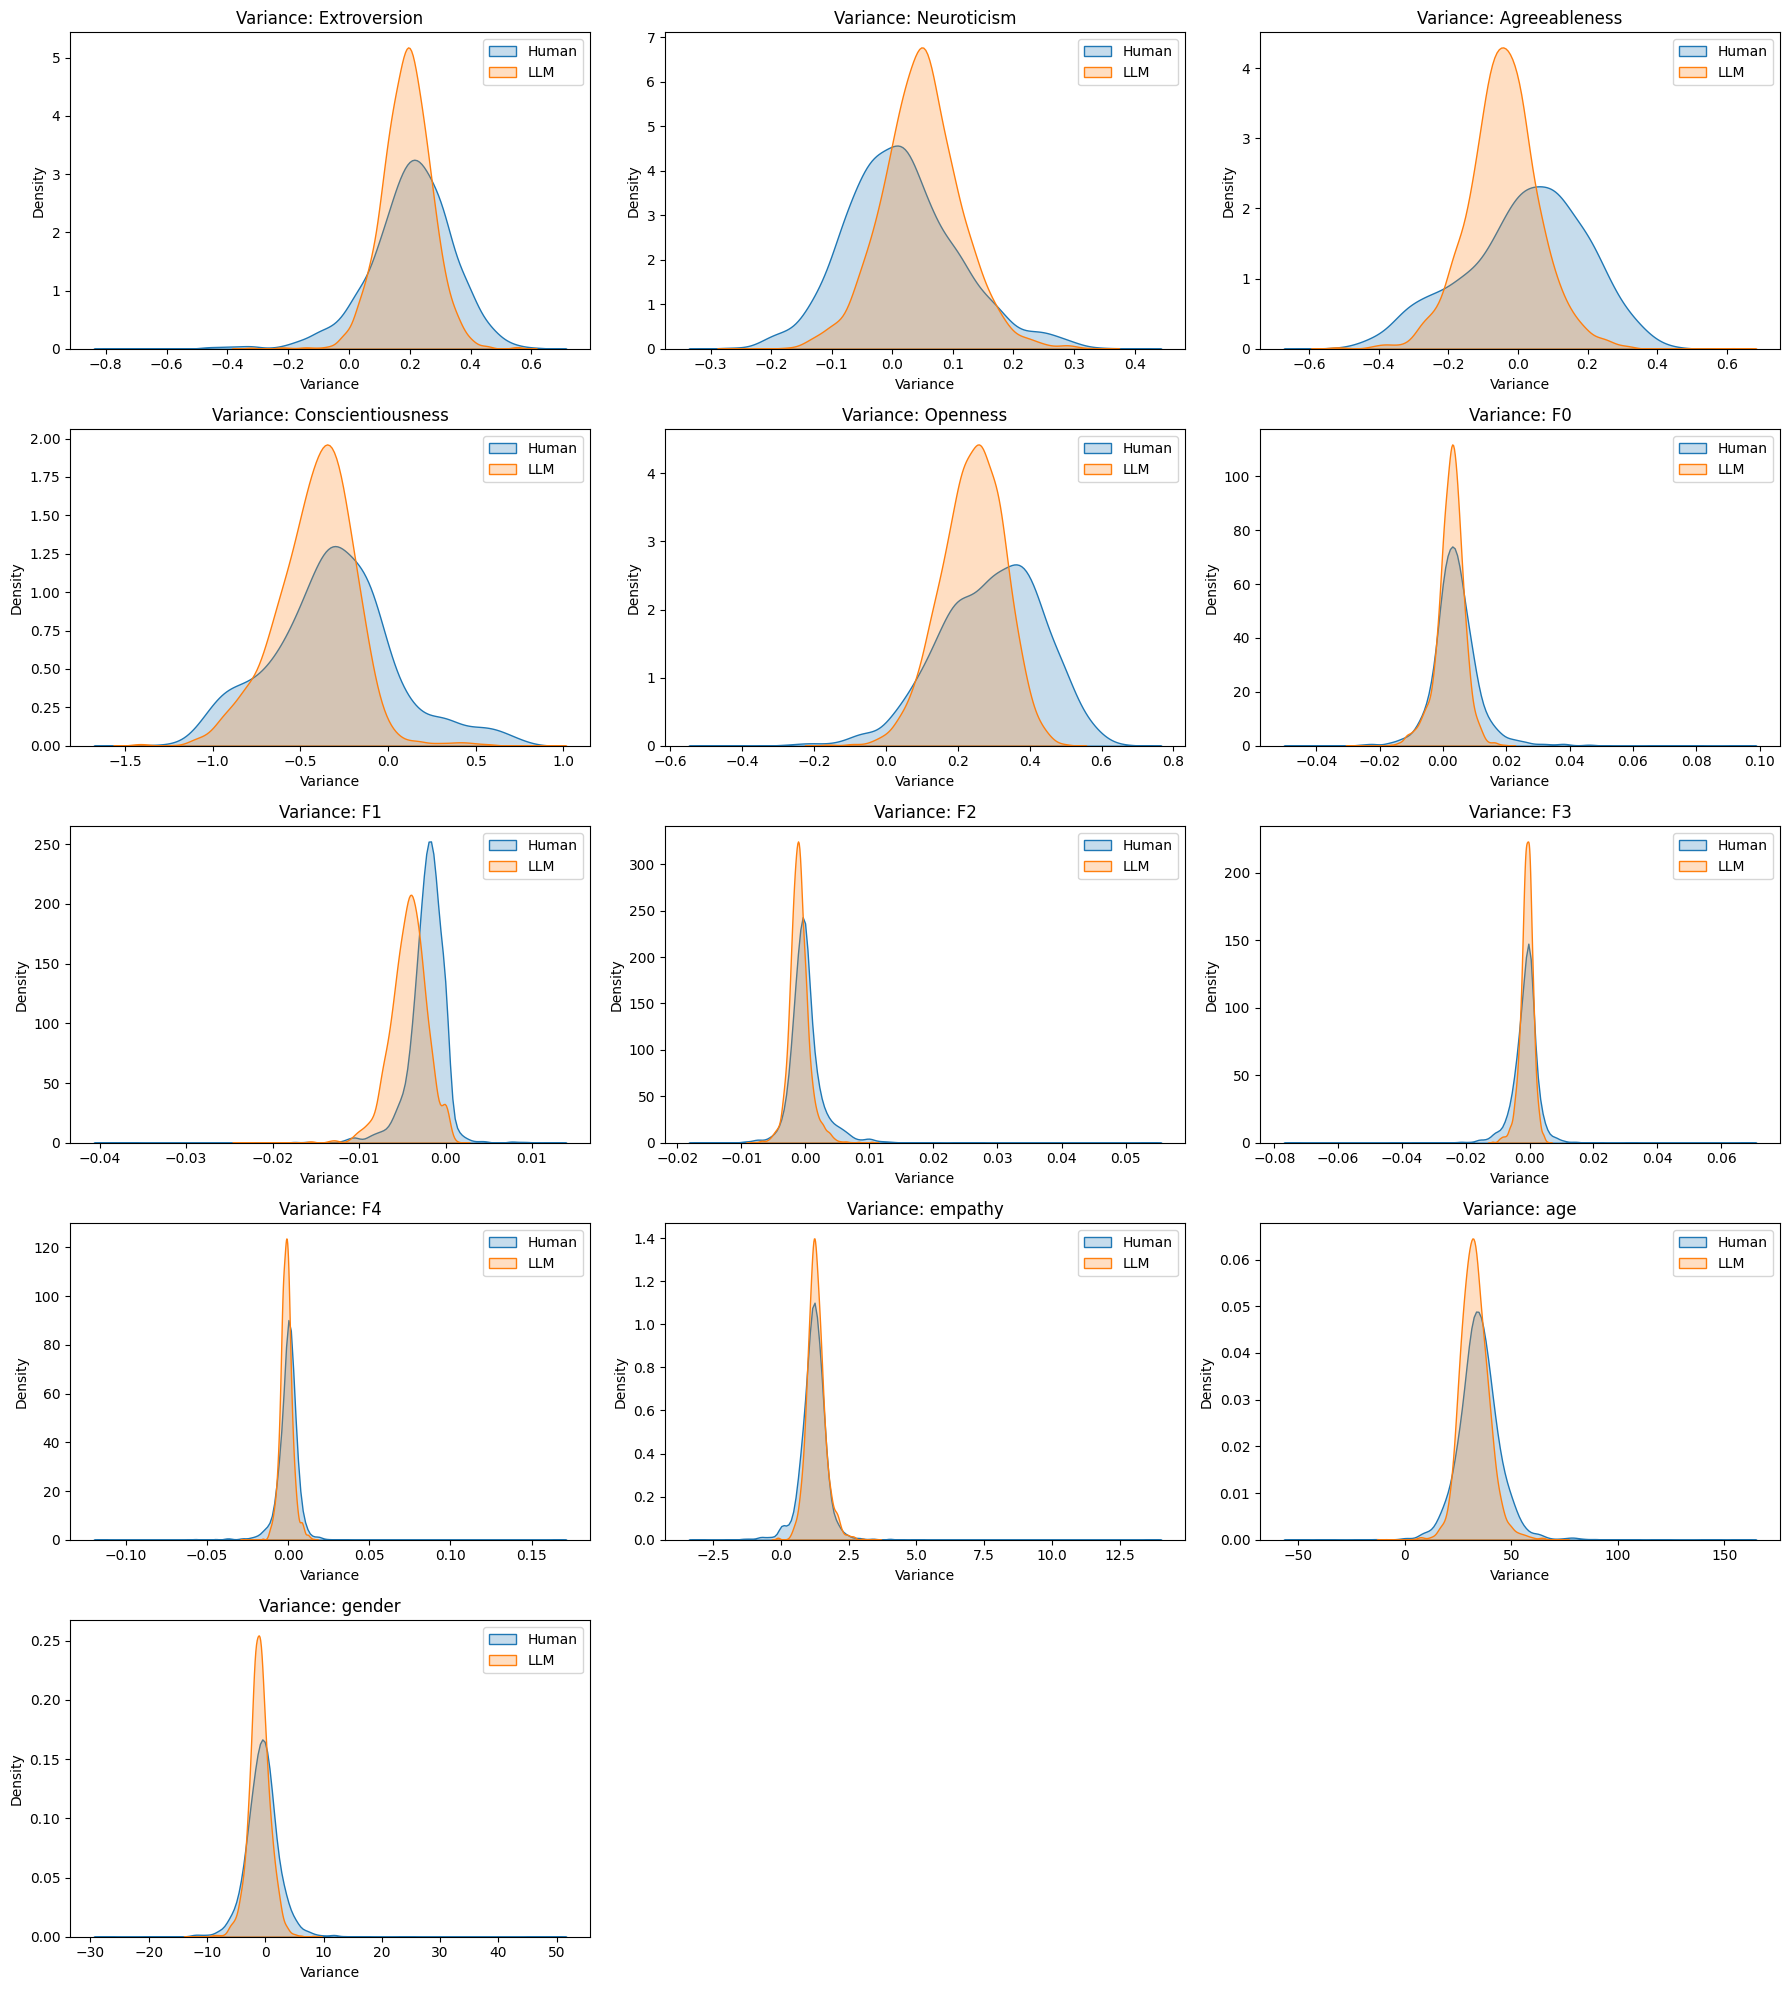

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of numerical features to compare
num_features = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness',
                'F0', 'F1', 'F2', 'F3', 'F4', 'empathy', 'age', 'gender']

n_traits = len(num_features)
n_cols = 3
n_rows = (n_traits + n_cols - 1) // n_cols  # Auto-calculate rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot per trait
for idx, trait in enumerate(num_features):
    sns.kdeplot(fake_human_written[trait], label='Human', fill=True, ax=axes[idx])
    sns.kdeplot(fake_llm_generated[trait], label='LLM', fill=True, ax=axes[idx])
    axes[idx].set_title(f'Variance: {trait}')
    axes[idx].set_xlabel('Variance')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("/home/ajha/AP2/data/variance_kde_plots_fake_articles.jpeg", dpi=300)
plt.show()

In [16]:
import pandas as pd
from scipy.stats import ks_2samp

# And num_features is defined as:
num_features = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness',
                'F0', 'F1', 'F2', 'F3', 'F4', 'empathy', 'age', 'gender']


ks_results = []

for feature in num_features:
    # Drop NaNs for fair comparison
    x = fake_llm_generated[feature].dropna()
    y = fake_human_written[feature].dropna()
    
    ks_stat, p_value = ks_2samp(x, y)
    
    ks_results.append({
        'Feature': feature,
        'KS Statistic': ks_stat,
        'p-value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

ks_table = pd.DataFrame(ks_results)


ks_table_sorted = ks_table.sort_values(by='KS Statistic', ascending=False).reset_index(drop=True)

def compute_js_divergence(x, y, bins=50):
    # Compute normalized histograms (probability distributions)
    p_hist, bin_edges = np.histogram(x, bins=bins, range=(min(x.min(), y.min()), max(x.max(), y.max())), density=True)
    q_hist, _ = np.histogram(y, bins=bin_edges, density=True)
    
    # Normalize to ensure sum = 1
    p = p_hist / np.sum(p_hist)
    q = q_hist / np.sum(q_hist)
    
    # Return JS divergence (squared to match divergence scale)
    return jensenshannon(p, q) ** 2

# Add JS Divergence to the table
js_divergences = []

for feature in ks_table_sorted['Feature']:
    x = fake_llm_generated[feature].dropna()
    y = fake_human_written[feature].dropna()
    js = compute_js_divergence(x, y)
    js_divergences.append(js)

ks_table_sorted['JS Divergence'] = js_divergences

print(ks_table_sorted)

              Feature  KS Statistic        p-value Significant  JS Divergence
0                  F1      0.486755  1.568592e-248         Yes       0.150103
1       Agreeableness      0.310962   4.137010e-99         Yes       0.106884
2            Openness      0.288704   2.691234e-85         Yes       0.089797
3                  F2      0.260826   1.605602e-69         Yes       0.045280
4         Neuroticism      0.248082   7.208463e-63         Yes       0.059550
5   Conscientiousness      0.212448   4.222052e-46         Yes       0.056721
6                  F4      0.202058   1.024026e-41         Yes       0.032011
7              gender      0.169192   2.504739e-29         Yes       0.031457
8        Extroversion      0.168613   3.954706e-29         Yes       0.052548
9                  F0      0.153513   3.328686e-24         Yes       0.033916
10                age      0.152065   9.327502e-24         Yes       0.028089
11                 F3      0.127821   6.713074e-17         Yes  